<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/QiskitVariationalClassifierFL_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
# installing TensorFLow Version 2.3.1
from IPython.display import clear_output

clear_output()

In [ ]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)



In [ ]:
import numpy as np
# Data Partitioning
NUM_CLIENTS = 5

# Split data and labels into 5 disjoint subsets
data_splits = np.array_split(TRAIN_DATA, NUM_CLIENTS)
label_splits = np.array_split(TRAIN_LABELS, NUM_CLIENTS)

# Create lists for each client's data and labels
clients_data = []
clients_labels = []
for i in range(NUM_CLIENTS):
    clients_data.append(data_splits[i])
    clients_labels.append(label_splits[i])

Whole code below

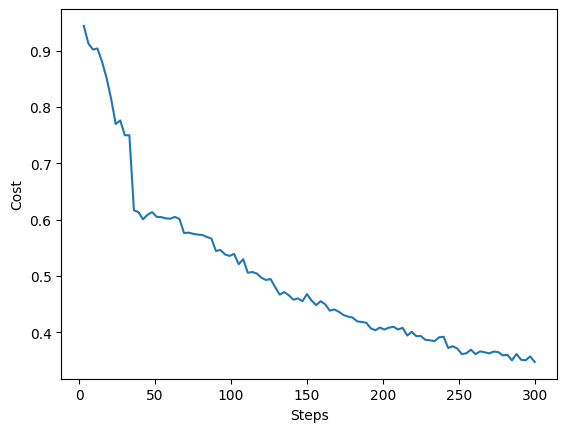

In [ ]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities


from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification

def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Implement with qiskit VQC


<ipython-input-8-94ec6b2353dc>:41: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=FEATURE_MAP,


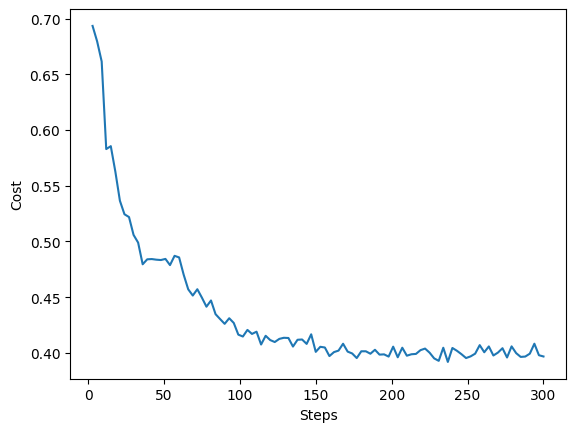

In [ ]:
from qiskit.utils import algorithm_globals
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(TRAIN_DATA, train_labels_oh)

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [ ]:
from qiskit.utils import algorithm_globals
import numpy as np
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit_machine_learning.optimizers import SPSA
from qiskit import BasicAer

# Set random seed
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)

# Define the feature map and variational form
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Combine feature map and variational form to create the circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()

# Generate ad hoc data for each client
def generate_client_data(client_id):
    TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
        ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, one_hot=False)
    )
    encoder = OneHotEncoder()
    train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)).toarray()
    test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)).toarray()

    return TRAIN_DATA, train_labels_oh, TEST_DATA, test_labels_oh

# Create a list of client data
client_data = [generate_client_data(client_id) for client_id in range(5)]

# Create a list of VQC instances, one for each client
clients = []
# Initialize an empty list to store client logs
client_logs = []
client_parameters = []
for client_id, data in enumerate(client_data):
    train_data, train_labels, _, _ = data
    log = OptimizerLog()
    vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))
    vqc.fit(train_data, train_labels)
    clients.append(vqc)
    client_logs.append(log)
    client_parameters.append(log.parameters)
    #print(client_parameters)

[[array([0.31007895, 0.66030755, 0.56989428, 0.97560703, 0.37249394,
       0.91397469, 0.83265824, 0.25815762, 0.60082114, 0.81307234,
       0.10794773, 0.306615  ]), array([ 1.02010511, -0.04971861, -0.14013188,  1.6856332 ,  1.0825201 ,
        0.20394853,  0.12263208, -0.45186855, -0.10920503,  0.10304617,
        0.81797389, -0.40341116]), array([ 1.09260907,  0.02278534, -0.06762793,  1.61312924,  1.01001615,
        0.27645248,  0.19513603, -0.5243725 , -0.03670107,  0.03054222,
        0.89047785, -0.47591512]), array([ 0.48455803,  0.63083638,  0.54042311,  2.22118028,  0.40196511,
        0.88450352,  0.80318707,  0.08367853, -0.64475211,  0.63859325,
        0.28242681, -1.08396615]), array([ 0.58111036,  0.72738871,  0.44387078,  2.12462795,  0.49851744,
        0.98105585,  0.70663474, -0.0128738 , -0.54819978,  0.54204092,
        0.18587448, -0.98741382]), array([ 0.27854078,  0.42481913,  0.1413012 ,  2.42719753,  0.19594786,
        0.67848627,  1.00920432, -0.3154433

KeyboardInterrupt: ignored

In [ ]:

# Aggregate parameters
aggregated_parameters = np.mean(client_parameters, axis=0)



In [ ]:
# Evaluate the global model
global_scores = []
for data in client_data:
    _, _, test_data, test_labels = data
    score = global_model.score(test_data, test_labels)
    global_scores.append(score)

# Display global model score
print(f"Global Model Test Scores: {global_scores}")

In [ ]:
# Evaluate the performance of each client
client_scores = []
for client_id, data in enumerate(client_data):
    _, _, test_data, test_labels = data
    vqc = clients[client_id]
    score = vqc.score(test_data, test_labels)
    client_scores.append(score)

# Display client scores
for client_id, score in enumerate(client_scores):
    print(f"Client {client_id+1} Test Score: {score}")

Client 1 Test Score: 1.0
Client 2 Test Score: 1.0
Client 3 Test Score: 1.0
Client 4 Test Score: 1.0
Client 5 Test Score: 1.0


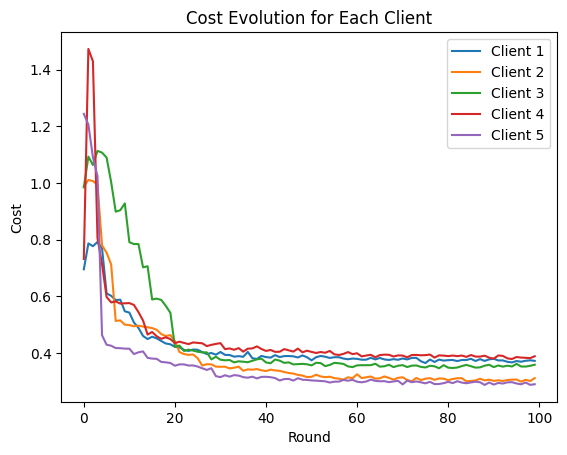

In [ ]:
# Evaluate the performance of each client over rounds
#rounds = 10  # Change this to the number of rounds you want to train

# Plot cost for each client over rounds
rounds = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(rounds), log.costs, label=f'Client {client_id + 1}')

plt.xlabel('Round')
plt.ylabel('Cost')
plt.title('Cost Evolution for Each Client')
plt.legend()
plt.show()





In [ ]:
#Global aggregation


In [ ]:
# Initialize an empty list to store aggregated parameters
aggregated_params = []

# Aggregate parameters using Federated Averaging
for param_index in range(len(clients[0].feature_map.parameters)):
    # Get parameters from each client's model
    client_params = [client.feature_map.parameters[param_index] for client in clients]

    # Calculate the average of parameters
    avg_param = np.mean(client_params, axis=0)
    aggregated_params.append(avg_param)

print(aggregated_params[0])

# Apply aggregated parameters to the global model
global_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
for param_index, param_value in enumerate(aggregated_params):
    global_feature_map.parameters[param_index] = param_value

# Create the global model
global_model = VQC(
    feature_map=global_feature_map,
    ansatz=VAR_FORM,
    loss='cross_entropy',
    optimizer=SPSA(),
    quantum_instance=BasicAer.get_backend('qasm_simulator')
)

# Evaluate the performance of the global model
for data in client_data:
    _, _, test_data, test_labels = data
    score = global_model.score(test_data, test_labels)
    print(f"Global Model Test Score: {score}")





x[0]


TypeError: ignored